## 1. 패키지 불러오기

In [2]:
import re
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from tqdm import tqdm

## 2. 데이터 불러오기

In [3]:
txt_list = glob.glob("./data/lyrics/*")

raw_corpus = []

for file in txt_list:
    with open(file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)
        
print(f"데이터 크기 : {len(raw_corpus)}")

데이터 크기 : 187088


In [4]:
len(raw_corpus)

187088

## 3. 텍스트 전처리 - 소문자화, 불용어 제거

In [5]:
# https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html
def text_preprocessing(corpus):
    corpus = corpus.lower()
    corpus = re.sub('[^a-z?\'!]', ' ', corpus)
    
    # 혼자 있는 따옴표 제거
    corpus = re.sub(' \' ', ' ', corpus)

    
    # 혼자있는 자음 제거
    tmp = None
    while tmp != corpus:
        tmp = corpus
        corpus = re.sub(" [xobgnerclfpkyvjhwzqstmd] ", ' ', corpus)
    
    corpus = re.sub("^[u] ", "you", corpus)
    corpus = re.sub(" [u]$", "you", corpus)
    corpus = re.sub("[ ]+", ' ', corpus)
    corpus = corpus.strip()
    
    
    # u를 you로 전환
    # corpus = re.sub("^<start> u ", '<start> you ', corpus)
    # corpus = re.sub(" u <end>$", ' you <end>', corpus)
    corpus = '<start> ' + corpus + ' <end>'
    corpus = corpus.strip()
    return corpus

# 전처리 적용
tmp = list(map(text_preprocessing, raw_corpus))
# 전처리 적용 후 단어가 없는 경우 제거
clean_corpus = []
for i in tmp:
    if len(i.split(" ")) > 0:
        clean_corpus += [i]

In [6]:
print(f"데이터 크기 : {len(clean_corpus)}")

데이터 크기 : 187088


In [8]:
clean_corpus[:20]

["<start> i hear you callin' here i come baby <end>",
 '<start> to save you oh oh <end>',
 "<start> baby no more stallin' <end>",
 '<start> these hands have been longing to touch you baby <end>',
 "<start> and now that you've come around to seein' it my way <end>",
 "<start> you won't regret it baby and you surely won't forget it baby <end>",
 "<start> it's unbelieveable how your body's calling for me <end>",
 "<start> i can just hear it callin' callin' for me my body's callin' for you <end>",
 "<start> my body's callin' for you <end>",
 "<start> my body's callin' for you <end>",
 "<start> my body's callin' for you tell me what's your desire <end>",
 '<start> baby your wish is my deal oh yes it is baby <end>',
 '<start> let me take you higher <end>',
 '<start> show you how you should feel baby <end>',
 '<start> oh so we speak now and forever hold your body <end>',
 '<start> whatever it is you want from me baby <end>',
 "<start> you see you don't have to say nothing <end>",
 '<start> kn

## 4. 텍스트 전처리 - 토큰화, 벡터화

In [9]:
split_corpus = list(map(lambda x : x.split(),clean_corpus))

tmp = defaultdict()
for corpus in split_corpus:
    for word in corpus:
        if word not in tmp:
            tmp[word] = corpus.count(word)
        else:
            tmp[word] += corpus.count(word)

tmp = dict(tmp)
word_count = sorted(tmp.items(), key = lambda x : x[1], reverse = True)

In [10]:
word_index = dict()
index_word = dict()
for ind, i in enumerate(word_count):
    word_index[i[0]] = ind + 1
    index_word[ind] = i[0]

word_index["<pad>"] = 0
index_word[0] = "<pad>"

vector_corpus = []
for corpus in tqdm(split_corpus):
    tmp = []
    if len(corpus) < 15:
        for i in corpus:
                tmp += [word_index[i]]
        vector_corpus += [tmp]

vector_corpus = tf.keras.preprocessing.sequence.pad_sequences(vector_corpus, padding="pre")

100%|██████████| 187088/187088 [00:00<00:00, 265856.06it/s]


In [11]:
vector_corpus

array([[    0,     0,     0, ...,    54,    37,     2],
       [    0,     0,     0, ...,    13,    13,     2],
       [    0,     0,     0, ...,    89, 10458,     2],
       ...,
       [    0,     0,     0, ...,    33,   116,     2],
       [    0,     0,     0, ...,    10,   152,     2],
       [    1,     6,    41, ...,   315,   315,     2]], dtype=int32)

In [28]:
# for i, j in word_count:
#     if len(i) == 1:
#         print(i, j)

In [29]:
# # u, x 만 있는 단어 찾기
# tmp = list(map(lambda x : len(re.findall(" q ", x)), clean_corpus))
# for i in range(len(clean_corpus)):
#     if tmp[i] != 0:
#         print(i, clean_corpus[i])

In [109]:
# split_corpus

# from gensim.models import Word2Vec
# word2vec_model = Word2Vec(vector_size = 300, window=5, min_count = 1, workers = 2)
# word2vec_model.build_vocab(split_corpus)
# word2vec_model.intersect_word2vec_format('./word2vec/GoogleNews-vectors-negative300.bin', lockf=1.0, binary=True)

# word2vev = Word2Vec(split_corpus)

# word2vev.wv

# tmp = []
# for corpus in split_corpus[:10]:
#     tmp += [list(map(lambda x: word2vev.wv[x], corpus))]

In [12]:
print(f"문장 갯수 : {vector_corpus.shape[0]}\n문장 길이 : {vector_corpus.shape[1]}")
print(f"텍스트에서 변환된 시퀀스 가장 큰 인덱스값 : {np.max(vector_corpus)}")

문장 갯수 : 169998
문장 길이 : 14
텍스트에서 변환된 시퀀스 가장 큰 인덱스값 : 31975


## 5. 학습데이터셋, 테스트데이터셋 분리 및 구축

In [13]:
seed = 305
np.random.seed(seed)
random_index = np.random.choice(range(len(vector_corpus)), 10000)
mini_vector_corpus = vector_corpus[random_index]

In [14]:
src_input = mini_vector_corpus[:, :-1]
tgt_input = mini_vector_corpus[:, 1:]

tr_src_input,te_src_input,tr_tgt_input,te_src_input = train_test_split(src_input,
                                                                      tgt_input,
                                                                      test_size = 0.2,
                                                                      random_state = seed) 

In [19]:
tr_src_input[:2], te_src_input[:2]

(array([[    1,   634,     9,    12,     7,   132,  2372,  6973,     5,
           889,    76,     7, 24147],
        [    0,     0,     0,     0,     0,     0,     1,     4,    31,
             3,    82,    46,   564]], dtype=int32),
 array([[   0,    0,    0,    0,    0,    1,  326,  135, 6818,  391,   53,
         3122,    2],
        [   0,    0,    0,    0,    0,    0,    1,    4,  703,   10, 6040,
         7551,    2]], dtype=int32))

In [168]:
buffer_size = len(tr_src_input)
batch_size = 64
steps_per_epoch = len(tr_src_input) // batch_size

vocab_size = len(word_count) + 1
dataset = tf.data.Dataset.from_tensor_slices((tr_src_input, tr_tgt_input))
dataset = dataset.shuffle(buffer_size)
dataset = dataset.batch(batch_size, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 13), (256, 13)), types: (tf.int32, tf.int32)>

## 6. 모델 구조 구축

In [169]:
embedding_size = 256
hidden_size = 1024

inputs = tf.keras.layers.Input(shape=(src_input.shape[1]))
layer = tf.keras.layers.Embedding(vocab_size, embedding_size)(inputs)
layer = tf.keras.layers.BatchNormalization()(layer) 
layer = tf.keras.layers.LSTM(hidden_size, return_sequences=True, kernel_initializer="he_normal")(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)

layer = tf.keras.layers.BatchNormalization()(layer) 
layer = tf.keras.layers.LSTM(hidden_size, return_sequences=True, kernel_initializer="he_normal")(layer)
layer = tf.keras.layers.Dropout(0.5)(layer)
# activation="softmax" 
layer = tf.keras.layers.BatchNormalization()(layer)
outputs = tf.keras.layers.Dense(vocab_size, kernel_initializer="he_normal")(layer)

model = tf.keras.Model(inputs, outputs)

## 7. 모델 학습

312/312 [==============================] - 181s 572ms/step - loss: 3.9942 - val_loss: 12.1049


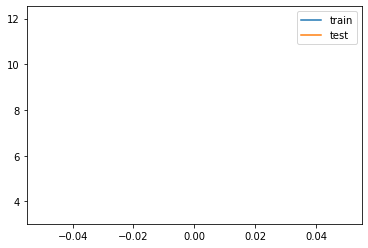

In [170]:
# Adam은 적응적 학습률 알고리즘이기에 학습률 파라미터의 튜닝의 필요성이 적습니다. - 핸즈온 머신러닝 441p
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=1)
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, min_delta=0.05)

model.compile(loss=loss, optimizer=optimizer)
history = model.fit(dataset, 
                    validation_data = (te_src_input, te_src_input),
                    callbacks = [es],
                    epochs=1)

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [96]:
model.save("./model/saved_model.h5")

## 8. 학습된 모델 확인

In [543]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [546]:
generate_text(model, tokenizer, init_sentence="<start> i")

'<start> i i i the the the the the <end> '

## 모델 성능 개선을 위한 노력
- 하이퍼 파라미터 조절
    1. vocab 사이즈 조절
    2. embedding 사이즈 조절
    3. hidden state 크기 조절
- 텍스트 데이터 전처리
- 외부 모델 불러오기

## 하이퍼 파라미터 조절

vocab size를 20,000 embedding size를 256 hidden state 크기를 1024로 하여 단순히 하이퍼 파라미터를 크게 한다고 좋은게 아니라고 느꼈습니다.

sentence: 10000  
vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.2 loss: 3.5306 - val_loss: 3.8973  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.05 loss: 3.5625 - val_loss: 3.9262  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.6373 - val_loss: 3.8414  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.8 loss: 3.8938 - val_loss: 3.8881 다시 val_loss가 상승함  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.3754 - val_loss: 4.2197 batchnormalization  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.5693 - val_loss: 3.8093 ReduceLROnPlateau  

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.5812 - val_loss: 3.8101 ReduceLROnPlateau batchnormalization 1개 epoch 9   

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.6421 - val_loss: 3.8326 ReduceLROnPlateau batchnormalization 2개   


sentence: full  
vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.5812 - val_loss: 3.8101 ReduceLROnPlateau batchnormalization 2개 

sentence: 20000  
vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.5812 - val_loss: 3.8101 ReduceLROnPlateau batchnormalization 2개 batch_size: 64

vocab_size: 31973 embedding_size: 256 hidden_size: 1024 dropout_rate: 0.5 loss: 3.5812 - val_loss: 3.8101 ReduceLROnPlateau batchnormalization 1개 batch_size: 64

## 텍스트 데이터 전처리

관사 a, an, the를 제외한 길이가 1인 단어는 모두 제거하기

중복되는 문장 제거하기는 오히려 성능의 저하가 발생하여 중복제거는 안하는 것이 좋다는 것을 알았습니다.  
중복 제거 전 : loss: 3.5905 - val_loss: 3.8269  
중복 제거 후 : loss: 3.9458 - val_loss: 4.1933

start 토큰과 end토큰을 없에고 하는것이 더 학습이 잘됩니다.